### 最初にqiskit-addon-sqdをインストール

In [ ]:
!pip install qiskit-addon-sqd

# QPEを使ったエネルギースペクトラムの推定

In [ ]:
import sys
import shutil
import tarfile
from google.colab import drive
drive.mount('/content/gdrive')
shutil.copy('/content/gdrive/MyDrive/qcintro.tar.gz', '.')
with tarfile.open('qcintro.tar.gz', 'r:gz') as tar:
    tar.extractall(path='/root/.local')

sys.path.append('/root/.local/lib/python3.11/site-packages')

!git clone -b branch-2025 https://github.com/UTokyo-ICEPP/qc-workbook-lecturenotes
!cp -r qc-workbook-lecturenotes/qc_workbook /root/.local/lib/python3.11/site-packages/

In [2]:
# まず必要なモジュールをインポートする
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh
import itertools

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as RuntimeSampler
from qiskit_ibm_runtime.accounts import AccountNotFoundError
from qiskit.visualization import plot_distribution

from qiskit.quantum_info import SparsePauliOp, Pauli, Statevector
from qiskit_addon_sqd.subsampling import postselect_and_subsample, subsample
from qiskit_addon_sqd.counts import generate_counts_uniform, counts_to_arrays
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates, project_operator_to_subspace

# ワークブック独自のモジュール
from qc_workbook.hamiltonian import make_hamiltonian
from qc_workbook.show_state import show_state

print('notebook ready')

notebook ready


スピン二つからなる系で、$J=1$、外部磁場なしの場合で、ハミルトニアンを対角化して厳密解を求める。

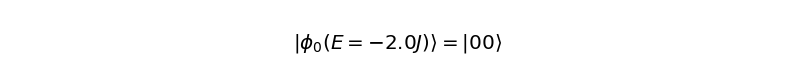

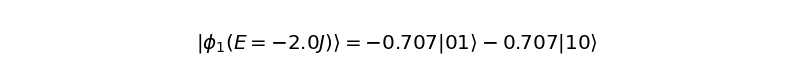

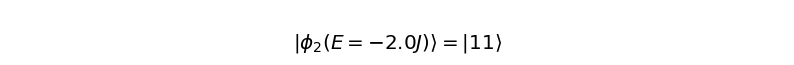

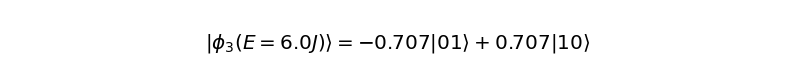

In [3]:
# Number of spins
n_s = 2
# Coupling parameter
J = 1.
# External field / J
g = 0.

# Construct the Hamiltonian matrix
paulis = list()
coeffs = list()
for j in range(n_s):
    paulis.append(list('x' if k in (j, (j + 1) % n_s) else 'i' for k in range(n_s)))
    coeffs.append(-J)
    paulis.append(list('y' if k in (j, (j + 1) % n_s) else 'i' for k in range(n_s)))
    coeffs.append(-J)
    paulis.append(list('z' if k in (j, (j + 1) % n_s) else 'i' for k in range(n_s)))
    coeffs.append(-J)
    if g != 0.:
        paulis.append(list('z' if k == j else 'i' for k in range(n_s)))
        coeffs.append(-J * g)

hamiltonian = make_hamiltonian(paulis, coeffs)

# Diagonalize and obtain the eigenvalues and vectors
eigvals, eigvectors = np.linalg.eigh(hamiltonian)

# Print the eigenvectors
for i in range(eigvals.shape[0]):
    show_state(eigvectors[:, i], binary=True, state_label=r'\phi_{} (E={}J)'.format(i, eigvals[i]))

## スペクトル推定を実装し、厳密解と照らし合わせる

**以下のセルでは、$U_H(-\tau)$を鈴木・トロッター分解した量子回路の1ステップ分の回路を使います。実際の回路は課題として提出してもらうので、ここから先はデモとして見せるだけにします（皆さんは授業では実行できません）。**

In [4]:
shutil.copy('/content/gdrive/MyDrive/Colab Notebooks/mymodule_heisenberg.py', '.')
import mymodule_heisenberg

次のセルでスペクトル推定のアルゴリズムを実装しています。この関数は状態レジスタ、読み出しレジスタ、時間発展回路を引数に取り、スペクトル推定の量子回路を返します。

In [5]:
def spectrum_estimation(state_register, readout_register, u_circuit):
    """Perform a spectrum estimation given a circuit containing state and readout registers and a callable implementing
    a single Trotter step.

    Args:
        state_register (QuantumRegister): State register.
        readout_register (QuantumRegister): Readout register.
        u_circuit (QuantumCircuit): A circuit implementing U_H(-2π/ω).
        
    Returns:
        QuantumCircuit: A circuit implementing the spectrum estimation of the given Hamiltonian.
    """
    circuit = QuantumCircuit(state_register, readout_register, name='Spectrum estimation')

    # Set the R register to an equal superposition
    circuit.h(readout_register)

    # Apply controlled-U operations to the circuit
    for iq, qubit in enumerate(readout_register):
        # Repeat the 2π evolution by 2^iq and convert it to a controlled gate
        controlled_u_gate = u_circuit.repeat(2 ** iq).to_gate().control(1)

        # Append the controlled gate specifying the control and target qubits
        circuit.append(controlled_u_gate, qargs=([qubit] + state_register[:]))
        
    circuit.barrier()

    # Inverse QFT
    for iq in range(readout_register.size // 2):
        circuit.swap(readout_register[iq], readout_register[-1 - iq])

    dphi = 2. * np.pi / (2 ** readout_register.size)

    for jtarg in range(readout_register.size):
        for jctrl in range(jtarg):
            power = jctrl - jtarg - 1 + readout_register.size
            circuit.cp(-dphi * (2 ** power), readout_register[jctrl], readout_register[jtarg])

        circuit.h(readout_register[jtarg])
        
    return circuit

上で厳密解を求めた$n=2$、$g=0$のケースを調べます。今回はすでにエネルギー固有値を知っているので、ハミルトニアンの規格化定数を$\hbar\omega=16J$として、読み出しレジスタの終状態が単純になるようにします。

In [6]:
## Physics model parameter
g = 0.

## Spectrum estimation parameters
# Hamiltonian normalization
energy_norm = 1. / 16. # J/(hbar*ω)
# Number of steps per 2pi evolution
# Tune this parameter to find the best balance of simulation accuracy versus circuit depth
num_steps = 6
# Register sizes
n_state = 2
n_readout = 4

## Registers
state_register = QuantumRegister(n_state, 'state')
readout_register = QuantumRegister(n_readout, 'readout')

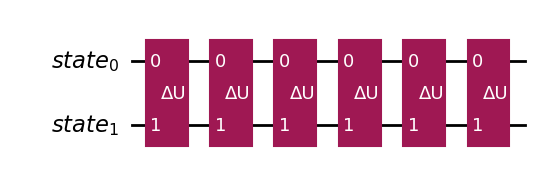

In [7]:
u_circuit = mymodule_heisenberg.trotter_twopi_heisenberg(state_register, energy_norm, g, num_steps)
u_circuit.draw('mpl')

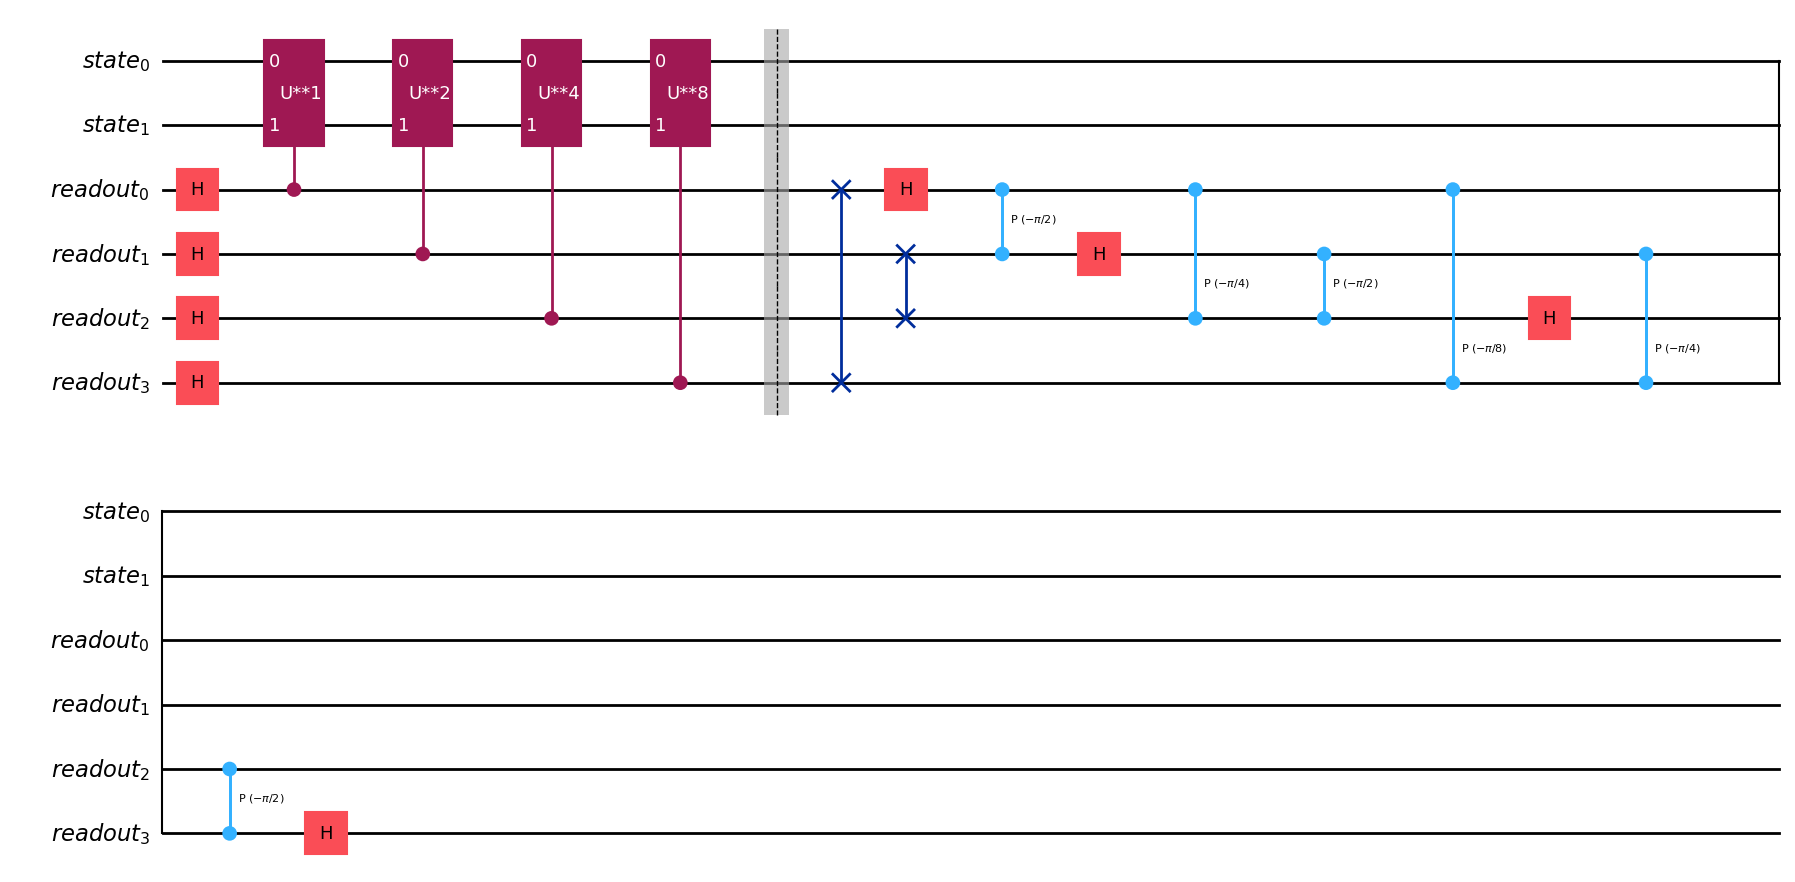

In [8]:
se_circuit = spectrum_estimation(state_register, readout_register, u_circuit)
se_circuit.draw('mpl')

状態レジスタの初期状態を基底状態$|\phi_0\rangle$、$|\phi_1\rangle$、$|\phi_2\rangle$、あるいは第1励起状態$|\phi_4\rangle$のどれかにして、正しく基底エネルギー（$-2J$）や第1励起エネルギー（$6J$）が得られるか確認します。

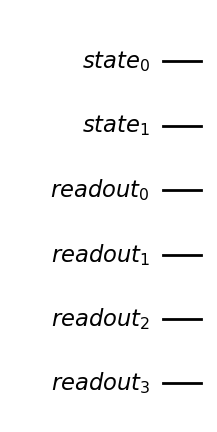

In [9]:
def make_initial_state(state_register, readout_register):
    circuit = QuantumCircuit(state_register, readout_register)

    ##################
    ### EDIT BELOW ###
    ##################

    # 基底状態: |00>
    # 基底状態: |11>
    #circuit.x(0)
    #circuit.x(1)
    # 基底状態: 1/sqrt(2)(-|01>-|10>)
    #circuit.?

    # 第1励起状態: 1/sqrt(2)(-|01>+|10>)    
    #circuit.?
    
    ##################
    ### EDIT ABOVE ###
    ##################
    
    return circuit


init_circuit = make_initial_state(state_register, readout_register)
init_circuit.draw('mpl')

全体の回路を作成して、実行します。

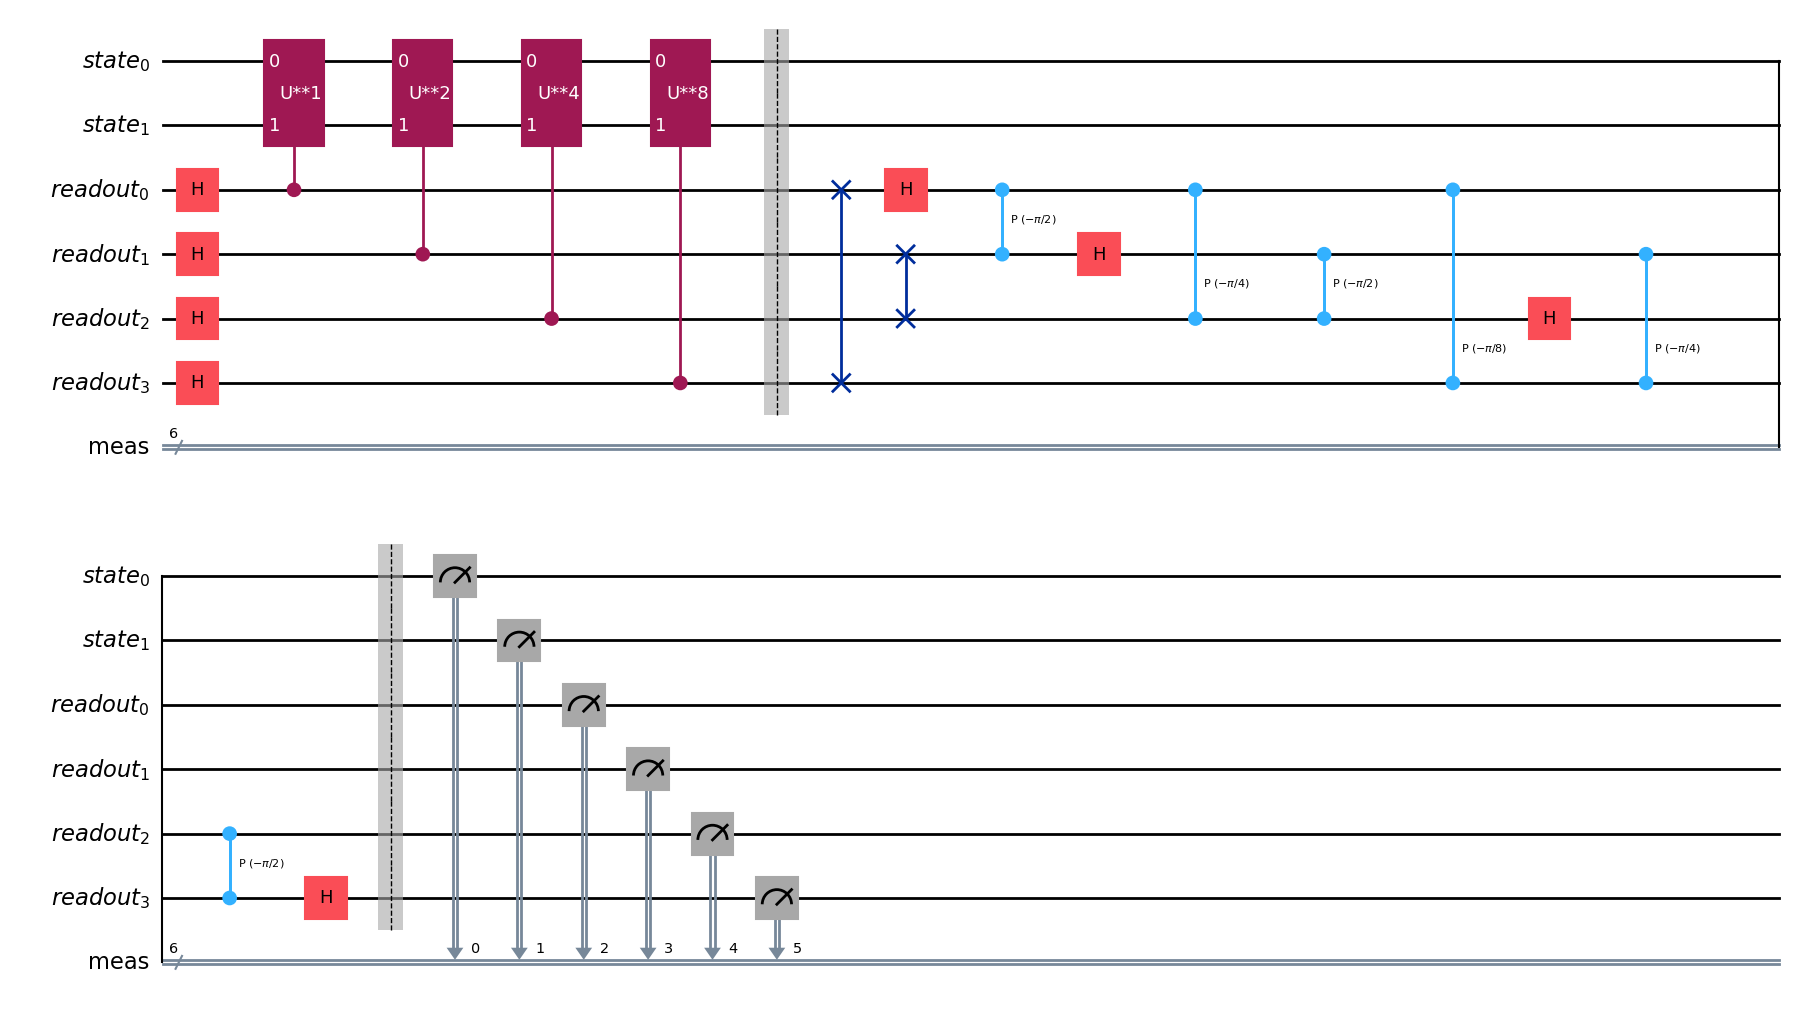

In [10]:
u_circuit = mymodule_heisenberg.trotter_twopi_heisenberg(state_register, energy_norm, g, num_steps)
se_circuit = spectrum_estimation(state_register, readout_register, u_circuit)

circuit = make_initial_state(state_register, readout_register)
circuit.compose(se_circuit, inplace=True)
circuit.measure_all()
circuit.draw('mpl')

得られた答えの解釈は課題の内容になるので、割愛します。

/opt/anaconda3/envs/env_qiskit_fy2025_code/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


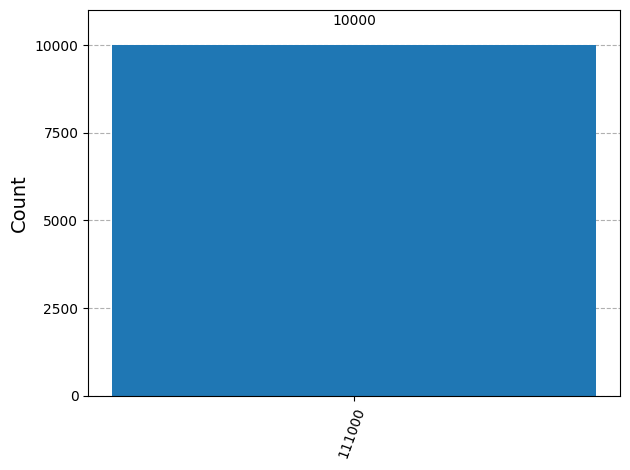

In [11]:
# Run the circuit in qasm_simulator and plot the histogram
simulator = AerSimulator()
circuit = transpile(circuit, backend=simulator)
job = simulator.run(circuit, shots=10000)
result = job.result()
counts = result.get_counts(circuit)
plot_distribution(counts)

## 部分空間での量子対角化法

ハイゼンベルク模型でのハミルトニアンを行列対角化し、エネルギー固有値を確認してみます。

In [13]:
# ハイゼンベルクハミルトニアン（行列）

# Number of spins
n_spins = 4
# Coupling parameter
J = 1.
# Boundary condition
PBC = False

# パウリ行列
X = np.array([[0, 1],[1, 0]], dtype=complex)
Y = np.array([[0, -1j],[1j, 0]], dtype=complex)
Z = np.array([[1, 0],[0, -1]], dtype=complex)
I = np.eye(2, dtype=complex)

def kron_n(mats):
    return reduce(np.kron, mats)

# 任意の n量子ビットのハイゼンベルク模型 (XX+YY+ZZ)
def heisenberg_hamiltonian(n, J=1.0, pbc=False):
    dim = 2**n
    H = np.zeros((dim, dim), dtype=complex)

    pairs = [(i, i+1) for i in range(n-1)]
    if pbc:
        pairs.append((n-1, 0))

    for i, j in pairs:
      for p in [X, Y, Z]:
        ops = [I]*n
        ops[i] = p
        ops[j] = p
        H += J * kron_n(ops)

    return H


H = heisenberg_hamiltonian(n_spins, J, PBC)
eigvals, _ = np.linalg.eigh(H)
print(f"N = {n_spins}, PBC = {PBC}")
print(f" 固有値: {np.round(eigvals, 6)}")
print(f" 基底エネルギー: {np.round(eigvals[0], 6)}")

N = 8, PBC = False
 固有値: [-13.49973  -11.928962 -11.928962 -11.928962 -10.014916 -10.014916
 -10.014916  -9.335215  -8.432517  -8.432517  -8.432517  -8.22703
  -8.22703   -8.22703   -7.668828  -7.395334  -7.395334  -7.395334
  -7.326454  -7.326454  -7.326454  -7.326454  -7.326454  -6.698825
  -6.698825  -6.698825  -6.580819  -5.862665  -5.862665  -5.862665
  -5.862665  -5.862665  -5.697661  -5.697661  -5.697661  -5.580043
  -4.913096  -4.913096  -4.913096  -4.902532  -4.902532  -4.902532
  -4.902532  -4.902532  -4.483928  -4.152416  -4.152416  -4.152416
  -4.152416  -4.152416  -3.986766  -3.986766  -3.986766  -3.931051
  -3.931051  -3.931051  -3.20968   -3.20968   -3.20968   -3.20968
  -3.20968   -2.916741  -2.916741  -2.916741  -2.909801  -2.909801
  -2.909801  -2.793709  -2.487072  -2.487072  -2.487072  -2.487072
  -2.487072  -2.485154  -2.466567  -2.466567  -2.466567  -1.943976
  -1.943976  -1.943976  -1.804268  -1.804268  -1.804268  -1.804268
  -1.804268  -1.788813  -1.788813  -1.7

基底状態を貼る部分空間が分かっている場合、その部分空間のみでハミルトニアンを対角化することで正しい基底エネルギーが得られることを確認します。
$N\ge4$については、磁化が0の部分空間を取ってくることにします。

In [14]:
basis = []

# n_spins = 2の場合:
#  サブスペース: |01>, |10>
if n_spins == 2:
#  basis = [np.array([0,1,0,0]),  # |01>
#           np.array([0,0,1,0])]  # |10>
#  サブスペース: 1/sqrt(2)(|01>-|10>) (singlet state)
  basis = [np.array([0,1/np.sqrt(2),-1/np.sqrt(2),0])]

# n_spins >= 4の場合:
#  サブスペース: 磁化0 (上向きと下向きスピンが同数)
elif n_spins >= 4:
  for i in range(2**n_spins):
    bits = bin(i).count('1')
    if bits == n_spins//2:
      vec = np.zeros(2**n_spins)
      vec[i] = 1
      basis.append(vec)

# Gram行列 S
S = np.array([[np.dot(b1.conj(), b2) for b2 in basis] for b1 in basis])

# 部分ハミルトニアン行列 H_sub
H_sub = np.array([[np.dot(b1.conj(), H @ b2) for b2 in basis] for b1 in basis])

# 部分空間で対角化
eigvals, _ = np.linalg.eigh(np.linalg.inv(S) @ H_sub)
print(f"N = {n_spins}, PBC = {PBC}")
print(f" 固有値: {np.round(eigvals, 6)}")
print(f" 基底エネルギー: {np.round(eigvals[0], 6)}")

N = 8, PBC = False
 固有値: [-13.49973  -11.928962 -10.014916  -9.335215  -8.432517  -8.22703
  -7.668828  -7.395334  -7.326454  -6.698825  -6.580819  -5.862665
  -5.697661  -5.580043  -4.913096  -4.902532  -4.483928  -4.152416
  -3.986766  -3.931051  -3.20968   -2.916741  -2.909801  -2.793709
  -2.487072  -2.485154  -2.466567  -1.943976  -1.804268  -1.788813
  -1.566811  -1.516072  -1.267014  -1.203733  -0.868139  -0.695518
  -0.481031  -0.314265  -0.19199   -0.06214    0.171573   0.510777
   0.67222    1.016921   1.283295   1.391365   1.421263   1.469266
   1.668828   2.141404   2.397986   2.587163   3.         3.1085
   3.258036   3.415389   3.803679   3.905145   4.157304   4.530734
   4.681872   4.745277   5.293715   5.530058   5.573364   5.828427
   5.974795   6.357412   6.695518   7.      ]
 基底エネルギー: -13.49973


ここから後は、qiskit_addon_sqdでサンプルベースの対角化をするため、SparsePauliOpでハミルトニアンを作っておきます。

In [15]:
# ハイゼンベルクハミルトニアン（パウリ行列）

# Number of qubits
n_qubits = 4
# Coupling parameter
J = 1.
# Boundary condition
PBC = False

# Construct Hamiltonian
def heisenberg_hamiltonian(n, J=1.0, pbc=False):
    paulis = []
    coeffs = []

    if pbc:
        pairs = [(i, (i + 1) % n) for i in range(n)]
    else:
        pairs = [(i, i + 1) for i in range(n - 1)]

    for i, j in pairs:
      for p in ['X', 'Y', 'Z']:
        s = ['I']*n
        s[i] = p
        s[j] = p
        paulis.append("".join(s))
        coeffs.append(J)

    H = SparsePauliOp(paulis, coeffs)
    return H

hamiltonian = heisenberg_hamiltonian(n_qubits, J, PBC)

# 固有値を計算（厳密対角化）
eigvals, eigvecs = np.linalg.eigh(hamiltonian.to_matrix())
gs_energy = eigvals[0]
print(f"固有値: {np.round(eigvals, 6)}")
print(f"基底エネルギー: {np.round(gs_energy, 6)}")

固有値: [-13.49973  -11.928962 -11.928962 -11.928962 -10.014916 -10.014916
 -10.014916  -9.335215  -8.432517  -8.432517  -8.432517  -8.22703
  -8.22703   -8.22703   -7.668828  -7.395334  -7.395334  -7.395334
  -7.326454  -7.326454  -7.326454  -7.326454  -7.326454  -6.698825
  -6.698825  -6.698825  -6.580819  -5.862665  -5.862665  -5.862665
  -5.862665  -5.862665  -5.697661  -5.697661  -5.697661  -5.580043
  -4.913096  -4.913096  -4.913096  -4.902532  -4.902532  -4.902532
  -4.902532  -4.902532  -4.483928  -4.152416  -4.152416  -4.152416
  -4.152416  -4.152416  -3.986766  -3.986766  -3.986766  -3.931051
  -3.931051  -3.931051  -3.20968   -3.20968   -3.20968   -3.20968
  -3.20968   -2.916741  -2.916741  -2.916741  -2.909801  -2.909801
  -2.909801  -2.793709  -2.487072  -2.487072  -2.487072  -2.487072
  -2.487072  -2.485154  -2.466567  -2.466567  -2.466567  -1.943976
  -1.943976  -1.943976  -1.804268  -1.804268  -1.804268  -1.804268
  -1.804268  -1.788813  -1.788813  -1.788813  -1.566811  -1

以下では、一様なビット列で構成された部分空間を使った例を考えてみます。

一様分布したビット列でハミルトニアンを対角化することは明らかに効率が悪いですが、ビット数が少なければ実行可能です。特に、部分空間の次元を上げて行った時に計算精度が向上していき、最終的に全空間を貼るビット列を使った時には厳密な基底エネルギーに到達することを見てみます。

In [ ]:
rng = np.random.default_rng(24)

# ビット列のサンプル数
#n_samples = 100
n_samples = 1000

# 一様分布に従うビット列を生成
counts = generate_counts_uniform(n_samples, n_qubits, rand_seed = rng)
#print(counts)

# ビット列からBool変数の行列を生成
bitstring_matrix_full, probs_array_full = counts_to_arrays(counts)
#print(bitstring_matrix_full)
#print(probs_array_full)

In [ ]:
# バッチの数
n_batches = 10
# バッチあたりのサンプル数
samples_per_batch = 4

# ビット列から部分空間に対応するサブサンプルを生成
batches_tmp = subsample(
    bitstring_matrix_full,
    probs_array_full,
    samples_per_batch = samples_per_batch,
    num_batches = n_batches,
    rand_seed = rng
)
#print(bitstring_matrix_full.shape)
#print(np.array(batches_tmp))
#print(np.array(batches_tmp).shape)

In [ ]:
print("部分空間に射影されたハミルトニアンの基底エネルギー：")

eigvals_min_batch = []

for j in range(n_batches):
  # ビット列の重複がある場合、重複している行列要素を除く
  batches_removed = sort_and_remove_duplicates(np.array(batches_tmp)[j])
  #print(j,batches_removed)

  # ハミルトニアンをbatched_removedが貼るヒルベルト空間に射影
  #d, _ = batches_removed.shape
  projected_hamiltonian = project_operator_to_subspace(batches_removed, hamiltonian, verbose=False)
  #print(j,projected_hamiltonian)

  # 射影されたハミルトニアンを対角化
  eigenvals, eigenstates = eigsh(projected_hamiltonian.toarray())
  #print(f"  バッチ {j} - 固有値: {np.round(eigenvals, 6)}")
  print(f"  バッチ {j} : {np.round(np.min(eigenvals), 6)}")

  eigvals_min_batch.append(np.min(eigenvals))

print(f"->最低エネルギー {np.round(np.min(eigvals_min_batch), 6)}")


In [ ]:
n_batches = 10

samples_per_batch_list = [1, 2, 3, 4, 5, 7, 9, 11, 13, 16]  # n_qubits = 4
#samples_per_batch_list = [1, 2, 5, 10, 20, 50, 100, 125, 150, 200, 225, 256]  # n_qubits = 8

batches_tmp_list = []
# ビット列から部分空間に対応するサブサンプルを生成
for i_samples in range(len(samples_per_batch_list)):
  batches_tmp = subsample(
      bitstring_matrix_full,
      probs_array_full,
      samples_per_batch = samples_per_batch_list[i_samples],
      num_batches = n_batches,
      rand_seed = rng
  )
  batches_tmp_list.append(batches_tmp)

In [ ]:
eigvals_min_batch_list = []

for i_samples in range(len(samples_per_batch_list)):

  for j in range(n_batches):
    # ビット列の重複がある場合、重複している行列要素を除く
    batches_removed = sort_and_remove_duplicates(np.array(batches_tmp_list[i_samples])[j])

    # ハミルトニアンをbatched_removedが貼るヒルベルト空間に射影
    projected_hamiltonian = project_operator_to_subspace(batches_removed, hamiltonian, verbose=False)

    # 射影されたハミルトニアンを対角化
    eigenvals, eigenstates = eigsh(projected_hamiltonian.toarray())
    #print(f"バッチ {j} : {np.round(np.min(eigenvals), 6)}")

  eigvals_min_batch_list.append(np.min(eigenvals))

  print(f"samples_per_batch = {samples_per_batch_list[i_samples]}, 最低エネルギー {np.round(np.min(eigenvals), 6)}")

In [ ]:
fig, ax = plt.subplots()
# Plot energies
ax.plot(samples_per_batch_list, eigvals_min_batch_list, label="measured energy", marker="o")
ax.set(xlabel='# of samples per batch', ylabel='Energy', title='Energy vs # of samples per batch')
ax.axhline(
    y=gs_energy,
    color="#BF5700",
    linestyle="--",
    label="exact energy",
)
ax.legend()

磁化0の初期状態を設定する回路を使った場合、エネルギーの収束性が改善すると期待されます。試してみましょう。

まずハミルトニアンを返す関数を定義します。

In [ ]:
def magnetization_zero_circuit(n):
    """
    任意の偶数量子ビット n に対して、
    磁化 0 (sum Z = 0) の均等重ね合わせ状態を作る量子回路。
    """
    if n % 2 != 0:
        raise ValueError("磁化0を作るには偶数量子ビットが必要です。")

    num_up = n // 2  # 磁化0なのでアップとダウンが同じ数

    # 磁化0サブスペースの基底状態（bit列）を列挙
    basis_states = []
    for up_positions in itertools.combinations(range(n), num_up):
        bits = ['0'] * n
        for i in up_positions:
            bits[i] = '1'
        basis_states.append("".join(bits))

    # 状態ベクトルを作成
    dim = 2**n
    state = np.zeros(dim, dtype=complex)
    for bitstr in basis_states:
        idx = int(bitstr, 2)
        state[idx] = 1.0 / np.sqrt(len(basis_states))

    # 初期化用回路
    qreg = QuantumRegister(n, name='qreg')
    creg = ClassicalRegister(n, name='out')
    qc = QuantumCircuit(qreg, creg)
    qc.initialize(state, range(n))
    qc.measure(qreg, creg)

    return qc, basis_states

In [ ]:
circuit, basis_states = magnetization_zero_circuit(n_qubits)
print("磁化0部分空間の基底状態:", basis_states)

ショット数を上と同じサンプル数にして、シミュレータで実行します。

In [ ]:
simulator = AerSimulator()
sampler = AerSampler()

circuit_transpiled = transpile(circuit, backend=simulator)
job = sampler.run([circuit_transpiled], shots=n_samples)

result = job.result()
plot_distribution(result[0].data.out.get_counts())

得られた結果から、上と同様にハミルトニアンを対角化してエネルギーを求めます。

In [ ]:
counts = result[0].data.out.get_counts()

# ビット列からBool変数の行列を生成
bitstring_matrix_full, probs_array_full = counts_to_arrays(counts)

n_batches = 10

samples_per_batch_list = [1, 2, 3, 4, 5, 7, 9, 11, 13, 16]  # n_qubits = 4
#samples_per_batch_list = [1, 2, 5, 10, 20, 50, 100, 125, 150, 200, 225, 256]  # n_qubits = 8

batches_tmp_list = []
# ビット列から部分空間に対応するサブサンプルを生成
for i_samples in range(len(samples_per_batch_list)):
  batches_tmp = subsample(
      bitstring_matrix_full,
      probs_array_full,
      samples_per_batch = samples_per_batch_list[i_samples],
      num_batches = n_batches,
      rand_seed = rng
  )
  batches_tmp_list.append(batches_tmp)

In [ ]:
eigvals_min_batch_list = []

for i_samples in range(len(samples_per_batch_list)):

  for j in range(n_batches):
    # ビット列の重複がある場合、重複している行列要素を除く
    batches_removed = sort_and_remove_duplicates(np.array(batches_tmp_list[i_samples])[j])

    # ハミルトニアンをbatched_removedが貼るヒルベルト空間に射影
    projected_hamiltonian = project_operator_to_subspace(batches_removed, hamiltonian, verbose=False)

    # 射影されたハミルトニアンを対角化
    eigenvals, eigenstates = eigsh(projected_hamiltonian.toarray())
    #print(f"バッチ {j} : {np.round(np.min(eigenvals), 6)}")

  eigvals_min_batch_list.append(np.min(eigenvals))

  print(f"samples_per_batch = {samples_per_batch_list[i_samples]}, 最低エネルギー {np.round(np.min(eigenvals), 6)}")

In [ ]:
fig, ax = plt.subplots()
# Plot energies
ax.plot(samples_per_batch_list, eigvals_min_batch_list, label="measured energy", marker="o")
ax.set(xlabel='# of samples per batch', ylabel='Energy', title='Energy vs # of samples per batch')
ax.axhline(
    y=gs_energy,
    color="#BF5700",
    linestyle="--",
    label="exact energy",
)
ax.legend()

### 量子コンピュータで実行してみる

まず、量子コンピュータで一様なビット列をサンプリングして試してみます。実機でのサンプリングにはノイズが入ってきますが、上の例から分かるように、部分空間の次元を上げていけばいずれ基底ネルギーに到達すると予想できます。

In [ ]:
qreg = QuantumRegister(n_qubits, name='qreg')
creg = ClassicalRegister(n_qubits, name='out')

circuit = QuantumCircuit(qreg, creg)
circuit.h(qreg)
circuit.measure(qreg, creg)

circuit.draw('mpl')

In [ ]:
# 量子コンピュータで実行する場合
runtime_config_path = '/content/gdrive/MyDrive/qiskit-ibm.json'
service = QiskitRuntimeService(filename=runtime_config_path)
#backend = service.least_busy(filters=operational_backend())

# 最も空いているバックエンドを見つけて、そのバックエンドに対して回路をトランスパイル
backend = service.least_busy(min_num_qubits=n_qubits, simulator=False, operational=True)
print(f"least busy backend: {backend.name}")

circuit_transpiled = transpile(circuit, backend=backend)

In [ ]:
sampler = RuntimeSampler(backend)

shots = 10000

job = sampler.run([circuit_transpiled], shots=shots)
print(f">>> Job ID: {job.job_id()}, Status: {job.status()}")

In [ ]:
#job = service.job("d1mgq7wzeebg0081rfrg")  # n_qubits = 4
print(f">>> Job Status: {job.status()}")

In [ ]:
result = job.result()
plot_distribution(result[0].data.out.get_counts())

部分空間の次元に対するエネルギーの依存性を確認します。

In [ ]:
counts = result[0].data.out.get_counts()

# ビット列からBool変数の行列を生成
bitstring_matrix_full, probs_array_full = counts_to_arrays(counts)

n_batches = 10

samples_per_batch_list = [1, 2, 3, 4, 5, 7, 9, 11, 13, 16]  # n_qubits = 4
#samples_per_batch_list = [1, 2, 5, 10, 20, 50, 100, 125, 150, 200, 225, 256]  # n_qubits = 8

batches_tmp_list = []
# ビット列から部分空間に対応するサブサンプルを生成
for i_samples in range(len(samples_per_batch_list)):
  batches_tmp = subsample(
      bitstring_matrix_full,
      probs_array_full,
      samples_per_batch = samples_per_batch_list[i_samples],
      num_batches = n_batches,
      rand_seed = rng
  )
  batches_tmp_list.append(batches_tmp)

In [ ]:
eigvals_min_batch_list = []

for i_samples in range(len(samples_per_batch_list)):

  for j in range(n_batches):
    # ビット列の重複がある場合、重複している行列要素を除く
    batches_removed = sort_and_remove_duplicates(np.array(batches_tmp_list[i_samples])[j])

    # ハミルトニアンをbatched_removedが貼るヒルベルト空間に射影
    projected_hamiltonian = project_operator_to_subspace(batches_removed, hamiltonian, verbose=False)

    # 射影されたハミルトニアンを対角化
    eigenvals, eigenstates = eigsh(projected_hamiltonian.toarray())
    #print(f"バッチ {j} : {np.round(np.min(eigenvals), 6)}")

  eigvals_min_batch_list.append(np.min(eigenvals))

  print(f"samples_per_batch = {samples_per_batch_list[i_samples]}, 最低エネルギー {np.round(np.min(eigenvals), 6)}")

In [ ]:
fig, ax = plt.subplots()
# Plot energies
ax.plot(samples_per_batch_list, eigvals_min_batch_list, label="measured energy", marker="o")
ax.set(xlabel='# of samples per batch', ylabel='Energy', title='Energy vs # of samples per batch')
ax.axhline(
    y=gs_energy,
    color="#BF5700",
    linestyle="--",
    label="exact energy",
)
ax.legend()

シミュレータを使った場合、磁化0の初期状態を設定する回路を使うとエネルギーの収束性が向上しました。実機ではどうなるでしょうか。

In [ ]:
circuit, basis_states = magnetization_zero_circuit(n_qubits)
print("磁化0部分空間の基底状態:", basis_states)

In [ ]:
# 最も空いているバックエンドを見つけて、そのバックエンドに対して回路をトランスパイル
backend = service.least_busy(min_num_qubits=n_qubits, simulator=False, operational=True)
print(f"least busy backend: {backend.name}")

circuit_transpiled = transpile(circuit, backend=backend, optimization_level=3)

In [ ]:
sampler = RuntimeSampler(backend)

job = sampler.run([circuit_transpiled], shots=shots)
print(f">>> Job ID: {job.job_id()}, Status: {job.status()}")

In [ ]:
#job = service.job("d1mg66rx3st0008yjrsg")  #n_qubits = 4
print(f">>> Job Status: {job.status()}")

In [ ]:
result = job.result()
plot_distribution(result[0].data.out.get_counts())

再度、部分空間の次元に対するエネルギーの依存性を確認します。

In [ ]:
counts = result[0].data.out.get_counts()

# ビット列からBool変数の行列を生成
bitstring_matrix_full, probs_array_full = counts_to_arrays(counts)

n_batches = 10

samples_per_batch_list = [1, 2, 3, 4, 5, 7, 9, 11, 13, 16]  # n_qubits = 4
#samples_per_batch_list = [1, 2, 5, 10, 20, 50, 100, 125, 150, 200, 225, 256]  # n_qubits = 8

batches_tmp_list = []
# ビット列から部分空間に対応するサブサンプルを生成
for i_samples in range(len(samples_per_batch_list)):
  batches_tmp = subsample(
      bitstring_matrix_full,
      probs_array_full,
      samples_per_batch = samples_per_batch_list[i_samples],
      num_batches = n_batches,
      rand_seed = rng
  )
  batches_tmp_list.append(batches_tmp)

In [ ]:
eigvals_min_batch_list = []

for i_samples in range(len(samples_per_batch_list)):

  for j in range(n_batches):
    # ビット列の重複がある場合、重複している行列要素を除く
    batches_removed = sort_and_remove_duplicates(np.array(batches_tmp_list[i_samples])[j])

    # ハミルトニアンをbatched_removedが貼るヒルベルト空間に射影
    projected_hamiltonian = project_operator_to_subspace(batches_removed, hamiltonian, verbose=False)

    # 射影されたハミルトニアンを対角化
    eigenvals, eigenstates = eigsh(projected_hamiltonian.toarray())
    #print(f"バッチ {j} : {np.round(np.min(eigenvals), 6)}")

  eigvals_min_batch_list.append(np.min(eigenvals))

  print(f"samples_per_batch = {samples_per_batch_list[i_samples]}, 最低エネルギー {np.round(np.min(eigenvals), 6)}")

In [ ]:
fig, ax = plt.subplots()
# Plot energies
ax.plot(samples_per_batch_list, eigvals_min_batch_list, label="measured energy", marker="o")
ax.set(xlabel='# of samples per batch', ylabel='Energy', title='Energy vs # of samples per batch')
ax.axhline(
    y=gs_energy,
    color="#BF5700",
    linestyle="--",
    label="exact energy",
)
ax.legend()

## 以下は余録
バッチ数に対する依存性はないことを確認

In [ ]:
n_batches_list = [10, 50, 100, 200]

samples_per_batch = 10

batches_tmp_list = []
# ビット列から部分空間に対応するサブサンプルを生成
for i_batch in range(len(n_batches_list)):
  batches_tmp = subsample(
      bitstring_matrix_full,
      probs_array_full,
      samples_per_batch = samples_per_batch,
      num_batches = n_batches_list[i_batch],
      rand_seed = rng
  )
  batches_tmp_list.append(batches_tmp)

In [ ]:
eigvals_min_batch_list = []

for i_batch in range(len(n_batches_list)):

  for j in range(n_batches_list[i_batch]):
    # ビット列の重複がある場合、重複している行列要素を除く
    batches_removed = sort_and_remove_duplicates(np.array(batches_tmp_list[i_batch])[j])

    # ハミルトニアンをbatched_removedが貼るヒルベルト空間に射影
    projected_hamiltonian = project_operator_to_subspace(batches_removed, hamiltonian, verbose=False)

    # 射影されたハミルトニアンを対角化
    eigenvals, eigenstates = eigsh(projected_hamiltonian.toarray())
    #print(f"バッチ {j} : {np.round(np.min(eigenvals), 6)}")

  eigvals_min_batch_list.append(np.min(eigenvals))

  print(f"n_batches = {n_batches_list[i_batch]}, 最低エネルギー {np.round(np.min(eigenvals), 6)}")

In [ ]:
fig, ax = plt.subplots()
# Plot energies
ax.plot(n_batches_list, eigvals_min_batch_list, label="energy error", marker="o")
ax.set(xlabel='# of batches', ylabel='Minimum energy observed', title='Observed minimum energy vs # of batches')